In [1]:
import accelerate
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import (
    DistilBertTokenizerFast, 
    DistilBertForSequenceClassification, 
    Trainer, 
    TrainingArguments
)
import seaborn as sns
import matplotlib.pyplot as plt

# Check versions
print(f"PyTorch: {torch.__version__}, Accelerate: {accelerate.__version__}")

c:\Users\ISAIAH\Desktop\ISAAA\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch: 2.7.0+cpu, Accelerate: 1.6.0


In [2]:

# Load data
df = pd.read_csv("../data/snopes_gmo_articles_cleaned.csv")
label_map = {
    'False': 0, 'Mostly False': 0, 'Unproven': 0, 'Outdated': 0,
    'True': 1, 'Mostly True': 1
}
df = df[df['Rating'].isin(label_map)].copy()
df['Label'] = df['Rating'].map(label_map)

# Tokenize
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Claim'], df['Label'], test_size=0.2, stratify=df['Label'], random_state=42
)

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=256)

# Dataset class
class GMODataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = GMODataset(train_encodings, train_labels.tolist())
val_dataset = GMODataset(val_encodings, val_labels.tolist())

# Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# TrainingArguments (CPU-optimized)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=6,
    per_device_train_batch_size=4,  # Reduced for CPU
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",  # Use "steps" if preferred
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=False,  # Disable mixed-precision on CPU
    no_cuda=True,  # Explicitly disable CUDA
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\ISAIAH\Desktop\ISAAA\venv\Lib\site-packages\transformers\training_args.py:1595: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.704800,0.697034
2,0.640400,0.591127
3,0.522100,0.445453
4,0.376400,0.368700
5,0.278900,0.409176
6,0.188700,0.417704


TrainOutput(global_step=60, training_loss=0.4518934408823649, metrics={'train_runtime': 135.1307, 'train_samples_per_second': 1.732, 'train_steps_per_second': 0.444, 'total_flos': 7083383672664.0, 'train_loss': 0.4518934408823649, 'epoch': 6.0})

In [3]:
# Evaluation
preds = trainer.predict(val_dataset)
y_pred = preds.predictions.argmax(axis=1)
print(classification_report(val_labels, y_pred, target_names=['False/Unproven', 'True']))

                precision    recall  f1-score   support

False/Unproven       0.90      1.00      0.95         9
          True       0.00      0.00      0.00         1

      accuracy                           0.90        10
     macro avg       0.45      0.50      0.47        10
  weighted avg       0.81      0.90      0.85        10



c:\Users\ISAIAH\Desktop\ISAAA\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ISAIAH\Desktop\ISAAA\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ISAIAH\Desktop\ISAAA\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


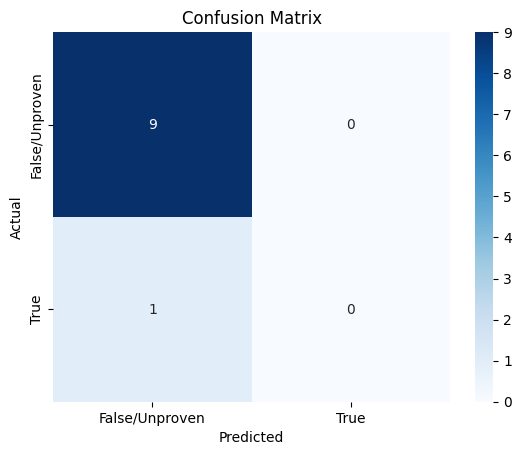

In [4]:
# Confusion Matrix
cm = confusion_matrix(val_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["False/Unproven", "True"], yticklabels=["False/Unproven", "True"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()